### 搭建的神经网络，使用olivettiface数据集进行训练

In [1]:
from sklearn.datasets import fetch_olivetti_faces

In [2]:
import os
os.makedirs('./face_data', exist_ok=True)  # 创建 data_home 目录

MNIST是来自torchvision.datasets的一个类，而fetch_olivetti_faces是来自scikit-learn的sklearn.datasets中的函数。  
这两个库的数据集加载方式有所不同。  
MNIST在初始化时接受参数如root、train、download和transform，而scikit-learn的fetch函数通常参数不同

fetch_olivetti_faces并没有train、root这些参数，而是使用data_home来指定数据存储路径。  
scikit-learn的数据集加载通常不会直接应用transform参数，因为返回的是numpy数组，而不是图像对象，所以需要用户自己处理转换

In [3]:
# 加载数据集  ​​40 个不同个体​​，每人 ​​10 张人脸图像​​，共 ​​400 张图像​​，以灰度图形式存储
olivetti_faces = fetch_olivetti_faces(data_home='./face_data', shuffle=True)
print(olivetti_faces.data.shape)
print(olivetti_faces.target.shape)
print(olivetti_faces.images.shape)

(400, 4096)
(400,)
(400, 64, 64)


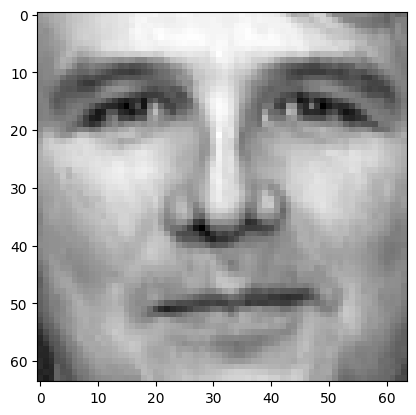

In [4]:
import matplotlib.pyplot as plt

face = olivetti_faces.images[8]
plt.imshow(face, cmap='gray')
plt.show()

In [5]:
olivetti_faces.data[399]

array([0.3966942 , 0.3677686 , 0.3429752 , ..., 0.37190083, 0.26859504,
       0.29752067], dtype=float32)

In [6]:
olivetti_faces.target

array([13, 30, 34, 19, 24,  6, 15, 26, 14, 21,  3, 13, 11, 34,  1,  5, 29,
       14, 20, 19, 17, 26, 12, 34, 17, 31,  7,  1, 28, 10, 17, 30, 33, 22,
        6,  7,  9, 17, 17, 39, 10, 32,  0,  0, 29,  5, 37, 25, 15, 23, 24,
       14, 29, 17, 28, 31,  5,  1,  2,  4,  7, 27,  0, 35, 19, 37, 14,  0,
       15, 31,  0, 26,  6,  2, 10,  1, 36, 30, 36, 32, 33,  6,  5, 10, 30,
       22, 12, 37, 39, 32, 38, 25,  5,  0, 19, 14, 13, 39, 26, 36, 25,  6,
       31, 15, 28, 34,  8, 34, 15, 29,  9,  8, 29,  2, 36, 21, 25,  4, 23,
       34,  9, 22, 23, 23, 37, 14,  2, 25, 35, 16, 15, 39,  6, 24, 21, 10,
       31, 19, 32,  1, 16, 18,  3, 11, 26, 10, 35, 24, 23, 11, 33, 12, 28,
       11, 21, 13, 27, 12, 19, 29, 28, 13,  3, 37, 16,  3, 23,  9,  8,  6,
       16, 28, 20, 39, 23, 28, 10,  4, 32, 39, 22,  7, 13, 38, 22, 21,  2,
       18, 36, 27,  5, 32, 35,  2,  0, 21, 15, 21, 37, 22, 13, 23, 21, 27,
       27, 30, 23,  3, 20, 39,  6,  2, 33,  4, 24, 12,  9, 11, 16, 38, 38,
       34,  4,  1, 28,  7

In [7]:
import torch
import torch.nn as nn

In [8]:

images = torch.tensor(olivetti_faces.data)
targets = torch.tensor(olivetti_faces.target)
print(images.shape)
print(targets.shape)

torch.Size([400, 4096])
torch.Size([400])


In [9]:
dataset = [(img,lbl) for img,lbl in zip(images, targets)]
print(dataset[0][0].shape)  # 64*64=4096,torch.Size([4096])
print(dataset[0][0])  # tensor(13, dtype=torch.int32)
print(dataset[0][1])  # tensor(13, dtype=torch.int32)
print(dataset[0])

torch.Size([4096])
tensor([0.6694, 0.6364, 0.6488,  ..., 0.0868, 0.0826, 0.0744])
tensor(13, dtype=torch.int32)
(tensor([0.6694, 0.6364, 0.6488,  ..., 0.0868, 0.0826, 0.0744]), tensor(13, dtype=torch.int32))


In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True) # 创建数据加载器
for data in dataloader:
    print(data[0].shape)  # torch.Size([10, 4096])
    print(data[1].shape)  # torch.Size([10])
    break  # 只打印第一个批次的数据
dataloader

torch.Size([10, 4096])
torch.Size([10])


In [11]:

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [12]:

# 多层神经网络模型
model = nn.Sequential(
    nn.Linear(4096, 8192),
    nn.ReLU(),
    nn.Linear(8192, 16384),
    nn.ReLU(),
    nn.Linear(16384, 1024),
    nn.ReLU(),
    nn.Linear(1024, 40)
).to(device)  # 模型结构搬到GPU内存中

print(model)


Sequential(
  (0): Linear(in_features=4096, out_features=8192, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8192, out_features=16384, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16384, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=40, bias=True)
)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
loss_hist = []
for i in range(10):
    for img,lbl in dataloader:
        img,lbl = img.to(device), lbl.to(device)  # 数据和模型在同一个设备端
        lbl = lbl.long()  # 将标签转换为 Long 类型 <<< 核心修复点
        result = model(img)
        loss = criterion(result, lbl)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist.append(loss.item())
        print(f'epoch:{i+1} loss:{loss.item():.4f}')

epoch:1 loss:3.6936
epoch:1 loss:53.2422
epoch:1 loss:6.3499
epoch:1 loss:3.9482
epoch:1 loss:3.5944
epoch:1 loss:4.2084
epoch:1 loss:4.0305
epoch:1 loss:3.6573
epoch:1 loss:3.7282
epoch:1 loss:3.7034
epoch:1 loss:3.7343
epoch:1 loss:3.7482
epoch:1 loss:3.7256
epoch:1 loss:3.7208
epoch:1 loss:3.7487
epoch:1 loss:3.6503
epoch:1 loss:3.7102
epoch:1 loss:3.7232
epoch:1 loss:3.7949
epoch:1 loss:3.6846
epoch:1 loss:3.6961
epoch:1 loss:3.7609
epoch:1 loss:3.6787
epoch:1 loss:3.7060
epoch:1 loss:3.7115
epoch:1 loss:3.7107
epoch:1 loss:3.7009
epoch:1 loss:3.6875
epoch:1 loss:3.6989
epoch:1 loss:3.6535
epoch:1 loss:4.3703
epoch:1 loss:3.7160
epoch:1 loss:3.6892
epoch:1 loss:3.7058
epoch:1 loss:3.7095
epoch:1 loss:3.6764
epoch:1 loss:3.6807
epoch:1 loss:3.7129
epoch:1 loss:3.7083
epoch:1 loss:3.6905
epoch:2 loss:3.5799
epoch:2 loss:3.7763
epoch:2 loss:3.7217
epoch:2 loss:3.8140
epoch:2 loss:3.7777
epoch:2 loss:3.6686
epoch:2 loss:3.6841
epoch:2 loss:3.7413
epoch:2 loss:3.6752
epoch:2 loss:3.7074

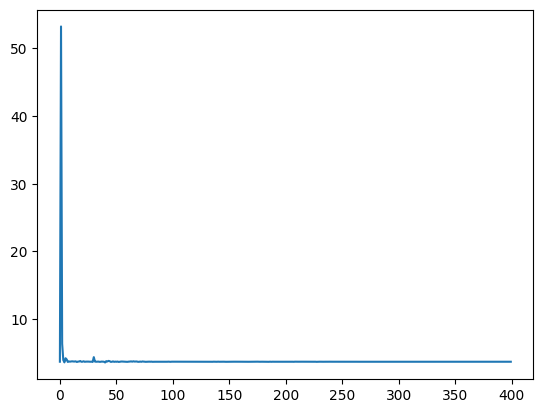

In [15]:
plt.plot(range(len(loss_hist)), loss_hist)
plt.show()